## Import and Load

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# seeds 
seed = 12341
np.random.seed(seed)
torch.manual_seed(seed)

In [23]:
train = pd.read_csv("data/ml-25m/ratings.csv").dropna().head(10000)
train['rating'] = train['rating'] / train['rating'].max()

train['user_id_for_model'] = train['userId'].astype('category').cat.codes
train['movie_id_for_model'] = train['movieId'].astype('category').cat.codes

train.head()

,userId,movieId,rating,timestamp,user_id_for_model,movie_id_for_model
0,1,296,1.0,1147880044,0,163
1,1,306,0.7,1147868817,0,167
2,1,307,1.0,1147868828,0,168
3,1,665,1.0,1147878820,0,352
4,1,899,0.7,1147868510,0,422


## PMF

In [113]:
from numpy.random import RandomState

class PMF(nn.Module):
	def __init__(self, n_users, n_items, n_factors=20, is_sparse=False, no_cuda=None):
		super(PMF, self).__init__()
		self.n_users = n_users
		self.n_items = n_items
		self.n_factors = n_factors
		self.random_state = RandomState(1)

		# M,D
		self.user_embeddings = nn.Embedding(n_users, n_factors, sparse=is_sparse)
		self.user_embeddings.weight.data = torch.from_numpy(self.random_state.rand(n_users, n_factors)).float()
		
		# NxD
		self.item_embeddings = nn.Embedding(n_items, n_factors, sparse=is_sparse)
		self.item_embeddings.weight.data = torch.from_numpy(self.random_state.rand(n_items, n_factors)).float()


		self.relu = nn.ReLU()
	
	def forward(self, users_index=None, items_index=None):
		if users_index is not None and items_index is not None:
			user_h1 = self.user_embeddings(users_index)
			item_h1 = self.item_embeddings(items_index)
			R_h = torch.dot(user_h1, item_h1)
		else:
			R_h = self.item_embeddings.weight.data @ self.user_embeddings.weight.data.T
		return nn.functional.sigmoid(R_h)

	def __call__(self, *args):
		return self.forward(*args)


	def predict(self, users_index=None, items_index=None):
		# preds = self.forward(users_index, items_index)
		if users_index and items_index:
			preds = self.forward(users_index, items_index)
		else:
			user_h1 = self.user_embeddings(users_index)
			item_h1 = self.item_embeddings(items_index)
			preds = (user_h1 * item_h1).sum(1)
		return preds


def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10


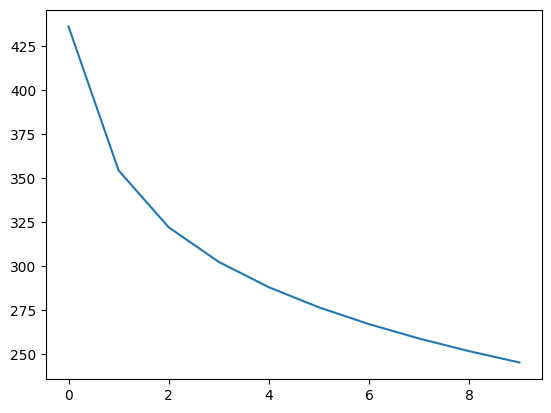

In [114]:
model = PMF(n_users=train['user_id_for_model'].max() + 1, n_items=train['movie_id_for_model'].max() + 1, n_factors=2)

epochs = 10
lr = 0.1
reg = 0.01

loss_SGD = []

for i in range(epochs):
    print("epoch", i + 1)
    interim = 0
    
    for _, row in train.iterrows():
      user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
      # making a pridiction in forward pass
      y_hat = model.forward(users_index=user, items_index=item)
      error = row['rating'] - y_hat

      interim += np.square(error.detach().numpy())
      
      # updates
      # Pi ← Pi + α(eij Qj − λPi ) 
      model.user_embeddings.weight.data[user, :] = \
        model.user_embeddings.weight.data[user, :] + \
        lr * (error * model.item_embeddings.weight.data[item, :] - reg * model.user_embeddings.weight.data[user, :])
      # Qj ← Qj + α(eij Pi − λQj )
      model.item_embeddings.weight.data[item, :] = \
        model.item_embeddings.weight.data[item, :] + \
        lr * (error * model.user_embeddings.weight.data[user, :] - reg * model.item_embeddings.weight.data[item, :])
    loss_SGD.append(interim)

plt.plot(loss_SGD)

In [115]:
preds = []
for _, row in train.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(model.forward(users_index=user, items_index=item).detach().numpy())

len(preds)

10000

In [116]:
import numpy as np
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse(train['rating'], np.array(preds))

0.1543629807374657

## TempMF

In [117]:
from numpy.random import RandomState

class TempMF(nn.Module):
	def __init__(self, n_users, t_steps, item_embeddings, n_factors=20, is_sparse=False, no_cuda=None):
		super(TempMF, self).__init__()
		self.n_users = n_users

		self.n_factors = n_factors
		self.random_state = RandomState(1)

		self.user_embeddings = torch.zeros([n_users, n_factors, t_steps])

		# N,D
		self.item_embeddings = item_embeddings

		self.relu = nn.ReLU()
	
	def forward(self, time_index, users_index=None, items_index=None):
		if users_index!=None and items_index!=None:
			user_h1 = self.user_embeddings[users_index,:,time_index]
			item_h1 = self.item_embeddings(items_index)
			R_h = torch.dot(user_h1, item_h1)
		else:
			R_h = self.item_embeddings.weight.data @ self.user_embeddings[:,:,time_index].T
		return nn.functional.sigmoid(R_h)

	def __call__(self, *args):
		return self.forward(*args)

	def predict(self, time_index, users_index=None, items_index=None):
		preds = self.forward(time_index, users_index, items_index)
		return preds

In [118]:
time_steps = 3
train_updated = (
    train
    .assign(bin = pd.cut(train.timestamp, bins = time_steps, labels=range(time_steps)))
    .sort_values('bin')
)

train_updated

,userId,movieId,rating,timestamp,user_id_for_model,movie_id_for_model,bin
7868,61,919,1.0,986611359,60,437,0
7808,61,82,0.8,986603962,60,53,0
7809,61,125,0.6,986605048,60,75,0
7810,61,153,0.8,986604153,60,83,0
7811,61,180,0.8,986609615,60,100,0
...,...,...,...,...,...,...,...
4517,29,4450,0.8,1340067706,28,1766,2
4516,29,3477,0.7,1340066099,28,1505,2
4515,29,3247,0.3,1340065797,28,1419,2
4513,29,2771,0.8,1340067801,28,1261,2


In [119]:
tempMF = TempMF(n_users=model.n_users, t_steps=time_steps, item_embeddings=model.item_embeddings, n_factors=model.n_factors)

epochs = 10
lr = 0.1
reg = 0.01

loss_SGD = []

# time
for t in range(time_steps):
    print("time:", t + 1)
    tempMF.user_embeddings[:,:,t] = model.user_embeddings.weight.data

    # iterations
    for iter in range(epochs):
      print(f"Epoch {iter}")
      interim = 0

      # ratings
      for _, row in train_updated[train_updated['bin'] == t].iterrows():
        user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
        y_hat = tempMF.forward(time_index=t, users_index=user, items_index=item)
        error = row['rating'] - y_hat
        interim += np.square(error.detach().numpy())
        
        tempMF.user_embeddings[user, :, t] = \
          tempMF.user_embeddings[user, :, t] + \
          lr * (error * tempMF.item_embeddings.weight.data[item, :] - reg * tempMF.user_embeddings[user, :, t])
      loss_SGD.append(interim)


time: 1
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
time: 2
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
time: 3
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


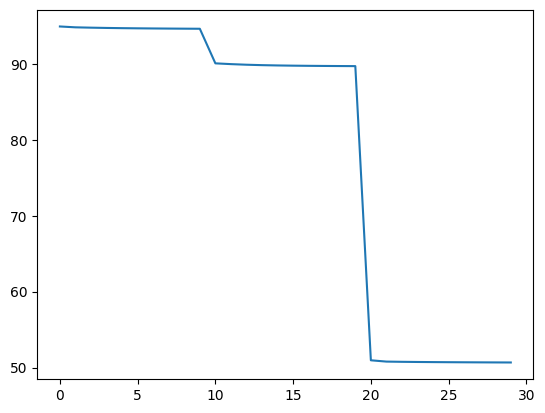

In [121]:
plt.plot(loss_SGD)

#### Lasso Regression: Drift

In [122]:
Z_t = torch.zeros([tempMF.n_users, tempMF.n_factors, time_steps - 1])
for i in range(time_steps - 1):
    Z_t[:,:,i] = tempMF.user_embeddings[:,:,i+1] - tempMF.user_embeddings[:,:,i]
Z_t

tensor([[[ 1.0388e-01, -1.0388e-01],
         [-7.3267e-02,  7.3267e-02]],

        [[-2.3831e-01,  2.3831e-01],
         [-1.1276e-01,  1.1276e-01]],

        [[ 0.0000e+00,  1.6114e-02],
         [ 0.0000e+00,  6.3812e-03]],

        [[ 0.0000e+00, -9.4330e-03],
         [ 0.0000e+00, -1.5125e-01]],

        [[-1.1196e-02,  0.0000e+00],
         [-3.6466e-04,  0.0000e+00]],

        [[-3.3684e-02,  0.0000e+00],
         [ 4.1241e-02,  0.0000e+00]],

        [[-1.4352e-02,  0.0000e+00],
         [-4.6449e-02,  0.0000e+00]],

        [[ 3.2945e-02,  0.0000e+00],
         [-1.8392e-01,  0.0000e+00]],

        [[-9.4510e-02,  0.0000e+00],
         [-4.4466e-02,  0.0000e+00]],

        [[ 7.4891e-03, -7.4891e-03],
         [ 1.2823e-01, -1.2823e-01]],

        [[-9.8770e-02,  9.8770e-02],
         [ 1.0271e-01, -1.0271e-01]],

        [[ 4.4603e-02,  2.4815e-01],
         [ 3.7457e-01,  6.7590e-02]],

        [[ 1.4597e-01, -1.4597e-01],
         [ 2.0574e-01, -2.0574e-01]],

        [[ 0

In [123]:
y = Z_t.detach()
X = tempMF.user_embeddings[:,:,1:].detach()
X.shape, y.shape

(torch.Size([75, 2, 2]), torch.Size([75, 2, 2]))

In [124]:
#Initializing weights and biases
A = torch.randn(tempMF.n_factors, tempMF.n_factors, requires_grad=True)
b = torch.randn(tempMF.n_factors, requires_grad=True)

# Define the model
def transition_model(x):
    return torch.einsum('idt,dd->idt', x, A) + b[:, None]

# regularization parameter
reg = 0.01
lr = 1e-4

#MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff*diff)/(2 * diff.shape[-1]) + reg * torch.norm(A, 1)

losses = []


# Train for 100 epochs
for i in range(250):
    preds = transition_model(X)
    loss = mse(preds, y)
    losses.append(loss.detach().numpy())
    if i == 0:
        loss.backward(retain_graph=True)
    else:
        loss.backward()
    with torch.no_grad():
        A -= A.grad * lr
        b -= b.grad * lr
        A.grad.zero_()
        b.grad.zero_()

# Calculate loss
preds = transition_model(X)
loss = mse(preds, y)
print(loss)

tensor(2.1588, grad_fn=<AddBackward0>)


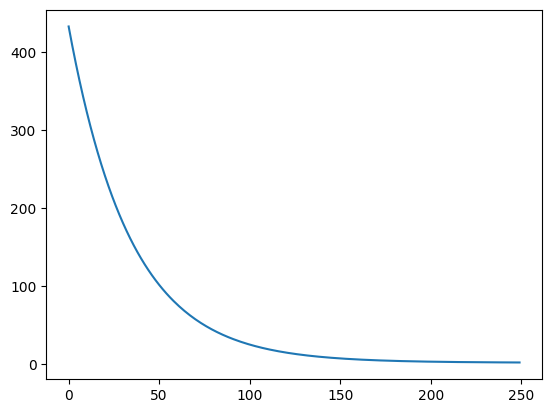

In [125]:
plt.plot(losses)

In [126]:
preds = []
for _, row in train_updated.iterrows():
    user, item = torch.tensor(row['user_id_for_model']).to(torch.int), torch.tensor(row['movie_id_for_model']).to(torch.int)
    preds.append(tempMF.forward(time_index = torch.tensor(row['bin']).to(torch.int), users_index=user, items_index=item).detach().numpy())

np.array(preds)

array([0.9079957 , 0.8215935 , 0.79530543, ..., 0.65046084, 0.6794095 ,
       0.5899632 ], dtype=float32)

In [127]:
rmse(train_updated['rating'], np.array(preds))

0.1530349670712741